<a href="https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural nets with micrograd
This is a Notebook to the free lecture [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0) by [Andrey Karpathy](https://github.com/karpathy).

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Understanding the derivative

## Derivative of a function with a single input

$$3x^2 - 4x + 5$$

In [4]:
def f(x):
  return 3*x**2 - 4*x +5

In [5]:
f(3.0)

20.0

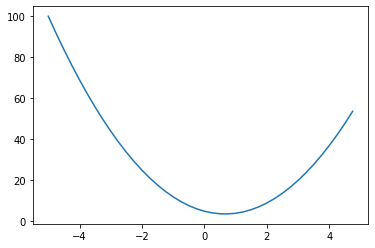

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Normally derivatives are derived directly from the mathematical expression of the base function. This is not done with neural networks. The fundemental definition of a derivative is stated as follows:

$$\frac{dy}{dx} = \lim_{h\to 0}\frac{f(x+h) - f(x)}{h}$$

By knowing this, the derivative can be derived by changeing the input by a small amount. Per definition the step of $h$ would be infinitly small.


In [7]:
h = 0.001
x = 3.0         # derviative at this point
print('x = ', x, ' h = ', h)
print('f(x) = ', f(x))
print('f(x + h) = ', f(x + h))
print('dy/dx = ', (f(x+h)-f(x))/h)

x =  3.0  h =  0.001
f(x) =  20.0
f(x + h) =  20.014003000000002
dy/dx =  14.00300000000243


## Derivative of a function with multiple inputs
Functions with a single input are fairly easy to derive mathematically, this changes with functions with multiple inputs and neural nets have many of them.

In [8]:
h = 0.001

# inputs (Point of derivation)
a = 2.0
b = -3.0
c = 10.0

# function
def f(a, b, c):
 return a*b + c

# derive
d1 = f(a, b, c)
print('d1 = ', d1)
c += h              # with respect to
d2 = f(a, b, c)
print('d2 = ', d2)
print('slope = ', (d2-d1)/h)

d1 =  4.0
d2 =  4.0009999999999994
slope =  0.9999999999994458


# Value class in micrograd

Micrograd provides a class *Value* for easy implementation and tracking of neural propagation. It initialy behaves as a normal scalar.

* Attribute ``data`` consists of the scalar value
* ``_prev`` provides a linked list along all of the operations
* ``_op`` stores the operation which lead to this node
* ``label`` is for visualization and documentation purposes for the function ``draw_dot()`` later on
* ``grad`` is the derivative in respect to a inputchange

**``grad``** describes how the output of a linked list of operations changes with the changes of the value of the corresponding node. The determination of these values is called **backpropagation**.



In [39]:
class Value:

  def __init__(self, data, _children=(), _op='', label = ''):# provide values for the attributes at runtime
    self.data = data
    self.grad = 0.0                 # affection of this value to the output
    self._backward = lambda: None   # function for backpropagation
    self._prev = set(_children)     # children variable keeps track of the values
                                    # which lead to this result
    self._op = _op                  # keeps track of the operations
    self.label = label              # for visualization purposes

  def __repr__(self):             # overwrites the standard return of the object
    return f"Value(data={self.data})"

  def __add__(self, other):       # what to do if two value objects are added
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad    # applying chainrule on a sum-node
      other.grad = 1.0 * out.grad
    out._backward = _backward       # store the function for backpropagation

    return out

  def __mul__(self, other):       # what to do if two value objects are multiplied
    out =  Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.grad * out.grad   # applying chainrule on times-node
      other.grad = self.grad * out.grad
    out._backward = _backward     # store the function for backpropagation
    return out

  def tanh(self):                 # implementing the tanh function
    x = self.data
    tanh = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out =  Value(tanh, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - tanh**2) * out.grad # derviative of tanh
    out._backward = _backward     # store the function for backpropagation
    return out

  

## Vizualisation
See [Sourcecode](https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb)

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

$a$ and $b$ are acting as node inputs, where as $c$ to $f$ act as the weights within the neural net. $grad$ describes how a valuechange of the corresponding node is influencing the output value.

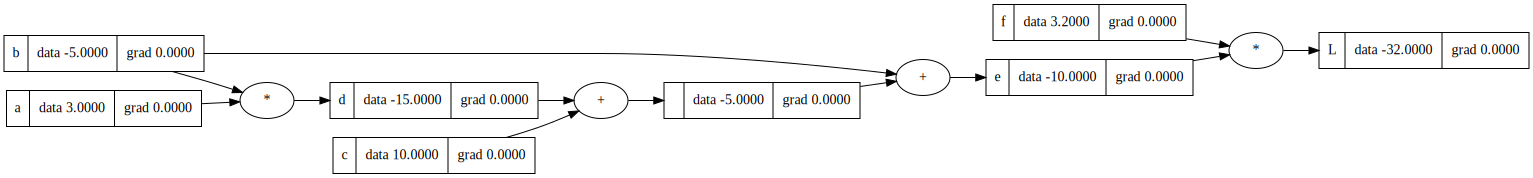

In [21]:
# testing
a = Value(3.0, label = 'a')
b = Value(-5.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c+b; e.label = 'e'
f = Value(3.2, label = 'f')
L = e*f; L.label = 'L'

# visualization
draw_dot(L)

## Determination of the gradient

### Manual backpropagation example #1: Simple expression

In [23]:
# testing
a = Value(3.0, label = 'a')
b = Value(-5.0, label = 'b')
c = Value(10.0, label = 'c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(3.2, label = 'f')
L = e*f; L.label = 'L'
print('L: \t', L)
print('_prev:\t', L._prev)
print('_op: \t', L._op)

L: 	 Value(data=-16.0)
_prev:	 {Value(data=-5.0), Value(data=3.2)}
_op: 	 *


First of we are going to determine the grad values by manual backpropagation:

* ``grad`` of $L$ will always be $1.0$ because we are calculating $\frac{dL}{dL} = 1$
* ``e.gard`` $= \frac{dL}{de} = \frac{d}{de}f*e = f$
* ``f.gard`` $= \frac{dL}{df} = \frac{d}{df}f*e = e$

*local derivative of the **Sum**-node, because we already know how $e$ is impacting $L$:*
* calculate $\frac{de}{dc} = \frac{d}{dc}c+d = 1$
* and by symmetry $\frac{de}{dd} = 1$

by applying the chainrule: **(Sum-nodes routes the derivative from the upper node to the two adjoining values "distributor")**
* ``c.grad`` $= \frac{dL}{dc} = \frac{dL}{de} * \frac{de}{dc} = e.grad * 1 = e.grad$
* ``d.grad`` $= \frac{dL}{dd} = \frac{dL}{de} * \frac{de}{dd} = e.grad * 1 = e.grad$

*local gradient of **Times**-node: (likewise as on the first node*
* $\frac{dd}{da} = \frac{d}{da}a*b = b$
* $\frac{dd}{db} = \frac{d}{db}a*b = a$

by appying the chainrule:
* ``a.grad`` $= \frac{dL}{da} = \frac{dL}{dd} * \frac{dd}{da} = d.grad * b$
* ``b.grad`` $= \frac{dL}{db} = \frac{dL}{dd} * \frac{dd}{db} = d.grad * a$

In [24]:
L.grad = 1
e.grad = f.data
f.grad = e.data
c.grad = e.grad
d.grad = e.grad
a.grad = d.grad * b.data
b.grad = d.grad * a.data


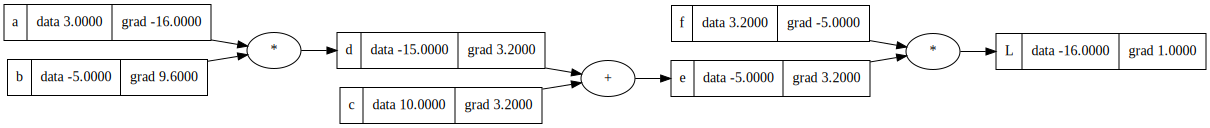

In [25]:
draw_dot(L)

## Manual backpropagation example #2: a neuron
First check [Quick intro to neurons](https://colab.research.google.com/github/AndreasMing/Learning/blob/main/NeuralnetsWithMicrograd.ipynb#scrollTo=TjxcqCslCnDr&line=1&uniqifier=1)

The following code lays out the basic maths of a neuron:

In [70]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b                   # broke up into smaller steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'       # cell boday raw activation w/o activation function
o = n.tanh(); o.label = 'o'           # output axon

In [64]:
# calculate derivatives by hand
o.grad = 1                      # derivative by itself
n.grad = 1 - o.data**2          # do/dn = 1 - tanh()**2

b.grad = n.grad                 # a plus is a distributor of gradient (n.grad*1)
x1w1x2w2.grad = n.grad          # n.grad * 1

x1w1.grad = x1w1x2w2.grad       # a plus is a distributor of gradient (n.grad*1*1)
x2w2.grad = x1w1x2w2.grad       # n.grad * 1 * 1

x1.grad = x1w1.grad * w1.data   # d/dx1 x1*w1 = w1      # chainroule: w1*x1w1.grad
w1.grad = x1w1.grad * x1.data   # symmetrical

x2.grad = x2w2.grad * w2.data   # d/dx2 x2*w2 = w2      # chainroule: w2*x2w2.grad
w2.grad = x2w2.grad * x2.data   # symmetrical


In [75]:
# calculate derivatives by function
o.grad = 1.0        # initialize the topmost grad
o._backward()   
n._backward() 
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


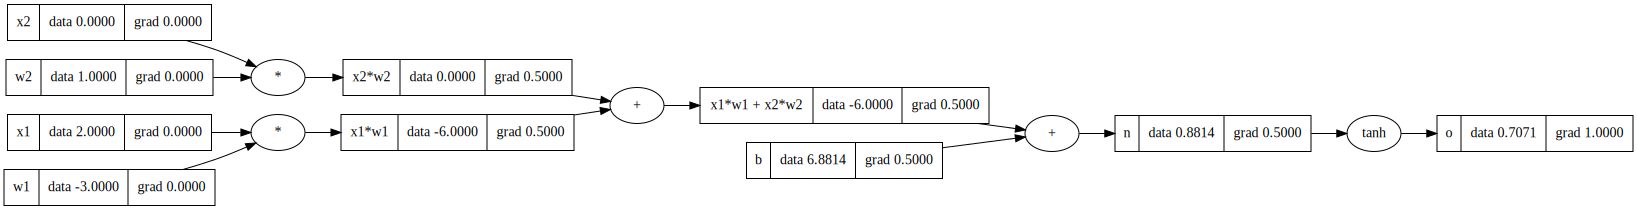

In [76]:
# visualization
draw_dot(o)

# Quick intro to neurons
A quick intro to neurons and its basic biological and mathematical modelling can be found on the [cs231n Lecture Page](https://cs231n.github.io/neural-networks-1/) by Stanford university.

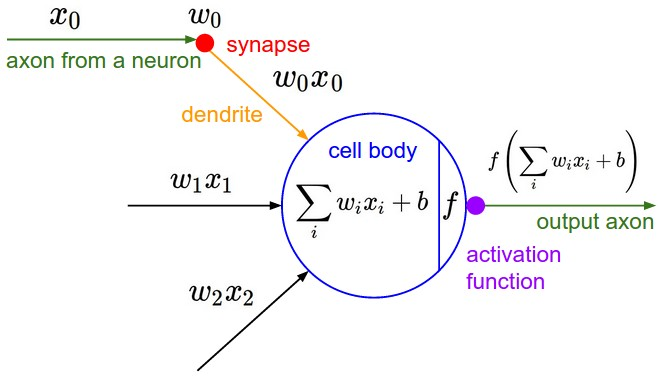

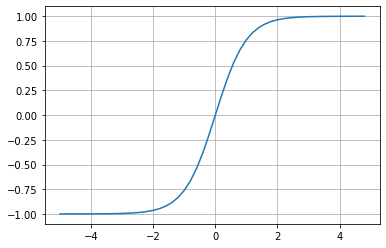

In [14]:
# example of the tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

As shown the ``tanh`` function squashes a given input inbetween $-1.0$ and $1.0$. Also see [Hyperbolic functions](https://en.wikipedia.org/wiki/Hyperbolic_functions)